In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Appendix A

## My Overview 

Let me start with my own intnroduction to this appendix. 

It turns out that an incredibly successful way to approach computer vision problems is to say:
> I have the _goal_ that I want to _optimize_, and I can express it via a _loss function_. 
> I want to choose some _parameters_ that _minimize my loss_, subject to some _constraints_ on thos parameters. 
> 

This is an _optimization_ problem, and you have likely seen them in your algorithms classes:
- The classic _Rod Cutting Problem_ used Dynamic Programming to solve for the optimal cuts to _maximize revenue_ by selling peices of a rod. 
- The _Fractional Knapsack_ problem and the _Scheduling Problem_ use a _Gready_ technique to optimize the amount you can fit into a knapsack, or the number of meetings you can schedule in a room.

A much more common example of an optimization problem is simply to have some _loss function_, $L(\mathbf{w})$ 
where $\mathbf{w} \in \mathcal{R}^n$ is a vector of parameters to your system, and $L(\mathbf{w})$ is a scalar values differentiable function.

Not all problems fit this mold, but you will find that _many_ important problems do.

Very often, the think you will be optimizing is the _probability_ that an image matches some interpretation. 
In this case you will also need to understand some statistics; and you will generally minimize the _negative log likelihood_ of the observation. 

You may or may not recall _Taylor's Theorem_ from calculus. 

It provides a formula to for a _local_ approximation to a $k$-times differentiable function using a $k^{th}$ order polynomial. 

A consequence of Taylor's theorem is that any twice differentiable function can be locally approximated by a polynomial

$f(w-\delta) = f(w) - \delta f'(w) + \frac{\delta^2}{2}f''(w) + \dots + (-\delta)^k f^{(k)} +  o(\delta^k)$

where $\delta$ is usually chosen _small_ so the polynomial is useful for approximiting a small region around some initial $w$. 

Note: I chose an offset of $-\delta$, somtimes you will see this written with a positive offset. It does not really matter what the sign is but I find this to be a useful notation in anticipation of th way we will use the series later. 

We _usually_ find that a _order 2_ or _quadritic_ polynomial is locally close enough to be useful.

Often (as is the case with neural networks) a linear approximation to the loss is sufficent as long as we stay within some _trust region_ close to the initial point.

In [2]:
from ipywidgets import interact
import sympy as sp

delta = np.linspace(-0.1, 0.1, 20)

f = sp.sympify("sin(2*pi*w)/2")
eval_f = sp.lambdify("w", f)

df = sp.diff(f, "w")
eval_df = sp.lambdify("w", df)

ddf = sp.diff(f, "w", "w")
eval_ddf = sp.lambdify("w", ddf)

@interact(w=(0.0, 1.0, 0.001))
def plot_approx(w=0.2):
    cla()
    scatter(w, eval_f(w))
    
    # The function
    plot(linspace(0, 1, 50), eval_f(linspace(0, 1, 50)), ls='--');
    
    # A Linear Approximation
    plot(w-delta, eval_f(w) -delta*eval_df(w), label="Linear")
    
    # A Quadratic Approximation
    plot(w-delta, eval_f(w)  - delta * eval_df(w) + delta**2/2 * eval_ddf(w), label="Quadratic")
    
    axis('scaled')
    ylim(-0.55, 0.55)
    legend();


ModuleNotFoundError: No module named 'sympy'

When we have functions of _multiple variables_  like $f(w_1, w_2, \dots, w_n)= f(\mathbf{w})$, then there is a different _partial derivative_ for each variable

$$\nabla[f] = \left[\begin{array} \\
                      \frac{\partial f}{\partial w_1}\\
                      \frac{\partial f}{\partial w_2}\\
                       \vdots \\
                      \frac{\partial f}{\partial w_n}\\
                   \end{array} \right]
$$
                      

The _nabla_ symbole ($\nabla$) is used to indicate the _gradient_ of a function, which is the vector of partial derivatives. 

The _Jacobian_ is the set of _second derivatives_

$$J[f] = 
\left[\begin{array} \\
      \frac{\partial^2 f}{\partial w_1^2} & \frac{\partial^2 f}{\partial w_1 \partial w_2} & \cdots &    \frac{\partial^2 f}{\partial w_1 \partial w_n}\\      
      \frac{\partial^2 f}{\partial w_1 \partial w_2} & \frac{\partial^2 f}{\partial w_2^2} & \cdots &    \frac{\partial^2 f}{\partial w_2 \partial w_n}\\
       \vdots & \vdots & \ddots & \vdots\\
      \frac{\partial^2 f}{\partial w_1 \partial w_n} & \frac{\partial^2 f}{\partial w_2 \partial w_n} & \cdots & \frac{\partial^2 f}{\partial w_n^2}\\
\end{array} \right]
$$

And the 2nd order Taylor series becomes

$$f(\mathbf{w}^* - \pmb{\epsilon}) = f(\mathbf{w}^*) - \pmb{\epsilon}^T\Delta[f](\mathbf{w}^*) + \frac{1}{2}\pmb{\epsilon}^T \mathbf{J}[f] \pmb{\epsilon} + o(||\pmb{\epsilon}||^2)$$ 

To help us understand this:
1. The vector $\pmb{\epsilon}$ is a small random offset from the inital vector $\pmb{w}^*$. 
2. The vector $\Delta[f]$ is the gradient of $f$
2. The _matrix_ $J[f]$ is a _symmetric_ matrix of mixed partial derivatives. 

If we want to _minimize_ the function $f(\mathbf{w})$ then we aim to find some $\mathbf{w}$ so that $\Delta[f]$ is zero.

Let us change variables, so $\mathbf{A} = \mathbf{J}[f]$ and $\mathbf{b}=\Delta[f]$.

Then we can rewrite $f(\mathbf{w}) \approx f(\mathbf{w}^*) - \pmb{\epsilon}^T \mathbf{b} + \frac{1}{2}\pmb{\epsilon}^T \mathbf{A} \pmb{\epsilon}$.

Although this might only be an approximation for $f$, we can solve for the $\pmb{\epsilon}$ that would make its derivative zero.

$f' \approx -\mathbf{b} +  \mathbf{A}\pmb{\epsilon}$

>  * The derivative $\frac{\partial}{\partial \epsilon_i} \left[\sum_i b_i \epsilon_i\right] = b_i$, so $\Delta[-\pmb{\epsilon}^T\mathbf{b}] = -\mathbf{b}$ .
>  * The derivative 
$$\begin{align}
\frac{\partial}{\partial \epsilon_i} \left[\pmb{\epsilon}^T \mathbf{A}\pmb{\epsilon}\right]
&= \frac{\partial}{\partial \epsilon_i} \left[\sum_i \sum_j A_{i,j} \epsilon_i \epsilon_j\right]\\
&= \frac{\partial}{\partial \epsilon_i} \left[A_{i,j} \epsilon_i \epsilon_j + A_{j,i} \epsilon_i \epsilon_j\right] & \text{(ignore terms without $\epsilon_i$)}\\
&= (A_{i,j} + A_{j,i})\epsilon_j,
\end{align}$$
so 
$$\begin{align}
\frac{1}{2}\Delta[\pmb{\epsilon}^T \mathbf{A}\pmb{\epsilon}] 
&= \frac{1}{2}(\mathbf{A} + \mathbf{A}^T)\pmb{\epsilon}  \\
&= \mathbf{A}\pmb{\epsilon} & \text{(since $\mathbf{A}=\mathbf{A}^T$)}\\
\end{align}
$$

and when $\mathbf{A}\pmb{\epsilon} = \mathbf{b}$ we have found a extreme value of the (approximation) to $f$, so we expect $f(\mathbf{w}^* - \pmb{\epsilon})$ to be a minimim of $|\mathbf{A}|>0$ 

## Matrix Decomposition

Based on the previous discussion, we expect that one of the main things we need to do is _solve systems of linear equations_ like $\mathbf{A}\pmb{\epsilon} = \mathbf{b}$ to find offsets ($\pmb{\epsilon}$) so that $-\pmb{\epsilon}$ points in the (approximate) direction of a minimim of $f$. 

In essence, we are trying to compute $\mathbf{A}^{-1}\mathbf{b}$, however we will find that one _rarely_ wishes to _actually_ calculate $\mathbf{A}^{-1}$ because it is hard to do so with limite-precision of our computers.

We often know some useful things about $\mathbf{A}$, especialluy since we know it is a Jacobian:

1. The matrix $\mathbf{A}$ for will be _symmetric_ for this type of problem.
2. If we can choose $f$ so that $\left\|J[f]\right\| > 0$ everywhere, then we know that the only stationary points are minima.  

A common approach to solving $\mathbf{Ax} = \mathbf{b}$ is to _factor_ $\mathbf{A}$ as a product of matrices that are simpler to solve. 

- Diagonal matrices (often called $\mathbf{D}$) are _very_ easy to invert; just invert the diagonal entries!
- Triangular matrices (zero below or above the diagonal) are easy to solve using backsubstitution or forward substitution. These are often called $\mathbf{L}$ or $\mathbf{R}$,or $\mathbf{U}$ as in "left right" or "lower upper". 
- _Orthogonal_ matrices (often called $\mathbf{Q}$ are very easy to invert since $\mathbf{Q}^{-1} = \mathbf{Q}^T$.  

## Singular Value Decomposition

The _Singular Value Decomposition_ (or SVD) is a very useful way to think about a transform. 

You are **given** :
 - A list of orthonormal _source directions_ $\mathbf{v}_1\dots\mathbf{v}_m$ as _unit_ vectors (so $\|\mathbf{v}_i\|  = 1$).  These specifiy _direction_ without scale.  These vectors may be part of an $n\geq m$ dimensional space.
 - A list of orthonormal _destination_ directions  $\mathbf{u}_1 \dots\mathbf{u}_m$ as _unit_ vectors. 
 - A list of _scales_ $\sigma_1 \dots \sigma_m$ 
 
Then the matrix $\mathbf{A} = \mathbf{U}\pmb{\Sigma}\mathbf{V}^T$ maps each $\mathbf{v}_i \mapsto \sigma_i\mathbf{u}_i$. 

This is a useful way to think about _every_ matrix $\mathbf{A}$ as a _transformation_ that _rotates_/_reflects_ one orthonormal coordinate system onto another, and also _scales_ it. 

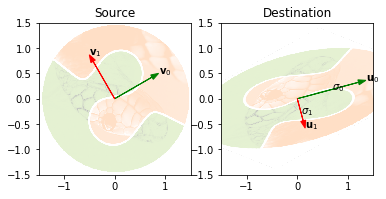

In [3]:
from numpy.linalg import norm, inv

from skimage.data import checkerboard, logo
from skimage.transform import warp


v0 = array([cos(radians(30)), sin(radians(30))])
v1 = array([cos(radians(30+90)), sin(radians(30+90))])

# A rotation of -15 degrees
u0 = array([cos(radians(15)), sin(radians(15))])
u1 = array([cos(radians(15+90)), sin(radians(15+90))])

# A reflection
u1 = -u1

# Scales (>= 0)
# --> List them in descending order, it is okay to swap them if you also swap U and V columns
s0 = 1.4
s1 = 0.6


U = np.column_stack([u0, u1])
Sigma = np.diag([s0, s1])
V = np.column_stack([v0, v1])

# The SVD
A = U.dot(Sigma).dot(V.T)

# Homogeneous coordinates (so we can warp an image)
A_h = eye(3); A_h[:2,:2] = A
im = logo()
w, h = im.shape[:2]

# Camera matrix for the image
view = np.array([[w/2., 0,    w/2.],
                 [0,    h/2., h/2.],
                 [0,    0,    1]])

# Warped image
im2 = warp(im, inv(view.dot(A_h.dot(inv(view))))  )

subplot(121)
title('Source')
imshow(im, origin='lower', alpha=0.25, extent=(-1.5, 1.5, -1.5, 1.5))
arrow(0,0, *v0, color='g', head_width=0.1, length_includes_head=True)
text(*v0, "$\mathbf{v}_0$")
arrow(0,0, *v1, color='r', head_width=0.1, length_includes_head=True)
text(*v1, "$\mathbf{v}_1$")

axis('scaled')
xlim(-1.5, 1.5)
ylim(-1.5, 1.5)

subplot(122)
title('Destination')
arrow(0,0, *s0*u0, color='g', head_width=0.1, length_includes_head=True)
text(*s0*u0, "$\mathbf{u}_0$")
text(*s0*u0/2., "$\sigma_0$")

arrow(0,0, *s1*u1, color='r', head_width=0.1, length_includes_head=True)
text(*s1*u1, "$\mathbf{u}_1$")
text(*s1*u1/2., "$\sigma_1$")

axis('scaled')
xlim(-1.5, 1.5)
ylim(-1.5, 1.5)

imshow(im2, alpha=0.25, origin='lower', extent=(-1.5, 1.5, -1.5, 1.5))

show()

In [4]:
from scipy.linalg import svd
U_, Sigma_, VT_ = svd(A)

The SVD is not necessarily unique, beut we try to list the columns so that $\sigma_i$ ar in _descending_ order. Still if it maps $\mathbf{U}$ to $\mathbf{V}$ it also maps $\mathbf{-U}$ to $\mathbf{-V}$, and vectors with equal $\sigma$ could be in any order. 

In [5]:
print(U.round(2))
print("-"*20)
print(U_.round(2))

[[ 0.97  0.26]
 [ 0.26 -0.97]]
--------------------
[[-0.97 -0.26]
 [-0.26  0.97]]


In [6]:
print(V.round(2))
print("-"*20)
print(VT_.T.round(2))

[[ 0.87 -0.5 ]
 [ 0.5   0.87]]
--------------------
[[-0.87  0.5 ]
 [-0.5  -0.87]]


In [7]:
print(diag(Sigma_))
print(Sigma)

[[1.4 0. ]
 [0.  0.6]]
[[1.4 0. ]
 [0.  0.6]]


The SVD can be used to compute $\mathbf{A}^{-1}$ because $\left(\mathbf{U}\times\text{diag}(\sigma_i)\times\mathbf{V}^T\right)^{-1}$ = $\mathbf{V}\times\text{diag}(\frac{1}{\sigma_i})\times\mathbf{U}^T$.

## QR Decomposition

The _SVD_ can be hard to compute, and it cannot be computed directly (one must use iterative / nonlinear techniques). 

The $\bf{A}=\bf{QR}$ decomposition provides a way to factor the matrix into easily invertible matrices $\mathbf{Q}$ so that $Q^{-1} = Q^T$ and $\bf{A}^{-1} = \bf{R}^{-1}\bf{Q}^T$

This factorization is useful because $\bf{Q}$ can be thought of as the axes of a _Cartesian Reference Frame_ and $\bf{R}$ can be thought of as a _Camera Matrix_ including translation, scaling, and skew.

In addition, the $\bf{QR}$ decomposution is numerically robust and can be solved directly. 

In [8]:
from scipy.linalg import qr

In [9]:
Q, R = qr(A)
print(Q)
print("-"*20)
print(R)

[[-0.87548236 -0.48325009]
 [-0.48325009  0.87548236]]
--------------------
[[-1.2489996  -0.5547002 ]
 [ 0.         -0.67253825]]


## The Choleski Decomposition

Since we often have a _symmetric positive definite_ matrix $\bf{C}$, then it can be expressed as the product $\bf{R}^2 = \bf{R}^T\bf{R}$. 

We call $\bf{R}$ the _square root_ of $\bf{A}$. 

The Choleski decomposition is _fast_ and _robust_ and _easy to compute_. 

In [10]:
from scipy.linalg import cholesky

C = np.random.rand(5, 5)
C = C.T.dot(C) # Make sure it is SPD

In [11]:
R = cholesky(C)
print(R)

[[ 1.30601295  0.91519548  0.98768028  0.98984663  1.23515625]
 [ 0.          0.88385443  0.18918042  0.86974888  0.02054567]
 [ 0.          0.          0.49315437 -0.15115108  0.216167  ]
 [ 0.          0.          0.          0.41759433  0.06542417]
 [ 0.          0.          0.          0.          0.12118754]]


In [12]:
np.allclose(R.T.dot(R), C)

True

# Least Squares

## Regular LS

Often, the function we want to minimize is a _mean squared error_ between some noisy observations and a parametric function. 

In [14]:
from scipy.stats import norm # A normal distribution
from easydict import EasyDict

In [15]:
noise = norm(loc=0, scale=0.05)

In [18]:
slope = 0.5
intercept  = 0.4

# Naming Convention -- Data, target
data = linspace(0, 1, 20)
target = slope*data  + intercept + noise.rvs(len(data))

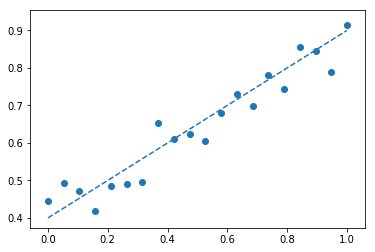

In [19]:
scatter(data, target)
plot(data, slope*data  + intercept, ls='--');

Our goal is then to find the parameters to the _best_ line. 

But what does _best_ mean?

The _*correct*_ answer may depend on our (often incomplete) understanding of the noise, and on prior knowledge of what kinds of line are more likely. 

A _common_ answer is the line that to minimize the variance of the error.

This means we want to minimize 
$$ \sum_{i} \| t_i - m x_i + b\|^2$$
by solving for unknowns $m, b$.

We can write this out using _matrices_ as follows:

$$ \mathbf{A} = \left[ \begin{array} \\ 1 & x_1 \\  1 & x_2 \\ \vdots & \vdots \\ 1 & x_n \end{array}\right]$$
$$ \mathbf{x} = \left[ b, m \right]^T$$
$$ \mathbf{b} = \left[ \begin{array} \\  t_1 \\  t_2 \\ \vdots  \\ t_n \end{array}\right]$$

And then we have $\mathbf{y} = \mathbf{A}\mathbf{x}$ and $y_i = b + x_1 \cdot m$.

> I am aware of the confusing notation regarding $\mathbf{x}$ and $x_i$, just go with it please. 

In [20]:
A = np.array([(1, x) for x in data])
x = np.zeros(2)
b = np.array(target)
print(A.round(2))
print(b.round(2))

[[1.   0.  ]
 [1.   0.05]
 [1.   0.11]
 [1.   0.16]
 [1.   0.21]
 [1.   0.26]
 [1.   0.32]
 [1.   0.37]
 [1.   0.42]
 [1.   0.47]
 [1.   0.53]
 [1.   0.58]
 [1.   0.63]
 [1.   0.68]
 [1.   0.74]
 [1.   0.79]
 [1.   0.84]
 [1.   0.89]
 [1.   0.95]
 [1.   1.  ]]
[0.44 0.49 0.47 0.42 0.49 0.49 0.5  0.65 0.61 0.62 0.61 0.68 0.73 0.7
 0.78 0.74 0.86 0.84 0.79 0.91]


We want to minimize $\frac{1}{2}\| \mathbf{b} - \mathbf{Ax} \|^2$

This means we want to set it's deriviative to zero. 


\begin{align}
(b - Ax)^2 &= (b-Ax)^T(b-Ax) \\
           &= b^T b - b^T Ax - (Ax)^T b - (Ax)^T Ax    & \text{(distributing)}\\
           &= b^2 - b^T Ax - x^T A^T b - x^T A^T A x   & \text{(since $(BC)^T = C^T B^T$) }\\
           &= b^2 - 2 x^T A^T b - x^T A^T A x          & \text{(since each term is scaler)}\\
\frac{\partial}{\partial x_i} (\cdot) 
           &= 2 A^T b - 2A^T A x                        & \text{(see my notes on derivative; $A^T b$ is a vector)} \\
\end{align}


to set its derivative to zero we must solve
$$ A^T A x = A^T b$$
which are called the _normal_ equations (they minimize normally distributed error, not sure if that is why)

In [21]:
from scipy.linalg import solve

In [22]:
print(A.T.dot(A))

[[20.         10.        ]
 [10.          6.84210526]]


In [23]:
print(A.T.dot(b))

[12.82937498  7.27395117]


We can solve this one by hand (!)

In [24]:
b, m = solve(A.T.dot(A), A.T.dot(b))

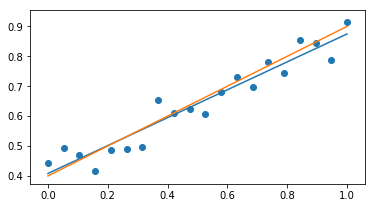

In [25]:
scatter(data, target)
plot(data, A.dot([b, m]))
plot(data, A.dot([intercept, slope]))
axis('scaled');

## Total Least Squares

An **implicit** function for a line is one where the line is where the _function is zero_. 

Implicit functions will often be defined in _one higher dimention_ then tha surfaces they describe.

Often, the implicit function is a _signed distance_, or at least it approximates one near the surface. 

For a line it is $$ a x + b y + c = 0. $$

In _Total Least Squares_ we want to minimize the _distance_ from the line (not just the vertical difference).

In [26]:
A = np.array([(x, y, 1) for (x, y) in zip(data, target)])
A.round(2)

array([[0.  , 0.44, 1.  ],
       [0.05, 0.49, 1.  ],
       [0.11, 0.47, 1.  ],
       [0.16, 0.42, 1.  ],
       [0.21, 0.49, 1.  ],
       [0.26, 0.49, 1.  ],
       [0.32, 0.5 , 1.  ],
       [0.37, 0.65, 1.  ],
       [0.42, 0.61, 1.  ],
       [0.47, 0.62, 1.  ],
       [0.53, 0.61, 1.  ],
       [0.58, 0.68, 1.  ],
       [0.63, 0.73, 1.  ],
       [0.68, 0.7 , 1.  ],
       [0.74, 0.78, 1.  ],
       [0.79, 0.74, 1.  ],
       [0.84, 0.86, 1.  ],
       [0.89, 0.84, 1.  ],
       [0.95, 0.79, 1.  ],
       [1.  , 0.91, 1.  ]])

In [27]:
x = np.zeros(3)  # a, b, c

Unfortunately, we are left with the squared error as minimize $\| 0 - Ax \|^2$.

The derivative is zero if $A^TAx = 0$. 

This clearly has a minimim at $0$ if $x=0$

Instead we must find $x$ so that $A^TAx$ is as small as possible, but $\|x\|=1$. 

It turns out we know how to do this
$$ A^TA = V\Sigma U^T U \Sigma v^T = V \Sigma^2 V^T $$

This is minimized for the column of $V$ correponding to the smallest $\sigma$.

In [28]:
from scipy.linalg import svd

In [29]:
U, sigma, VT = svd(A)
V = VT.T

In [30]:
sigma

array([5.82924459, 1.22559535, 0.15797596])

In [31]:
a, b, c = V[:, np.argmin(sigma)]  # We actually know it is index -1, but I wanted to show you argmin

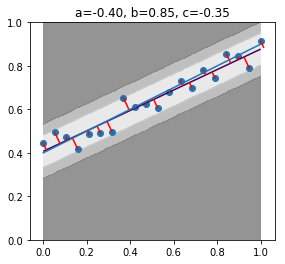

In [32]:
X, Y = mgrid[0:1:20j, 0:1:20j]
d = a*X + b*Y + c

contourf(X, Y, exp(-(d**2)/(0.1**2)), levels=linspace(0, 1, 4), cmap=cm.binary_r, alpha=0.5)
contour(X, Y, d, levels=0)

title(f"a={a:0.2f}, b={b:0.2f}, c={c:0.2f}")

# Closest points
for x, y in zip(data, target):
    dist = a*x + b*y +  c
    cx = x - a*dist/hypot(a,b)
    cy = y - b*dist/hypot(a,b)
    plot([x, cx], [y, cy], c='r')

scatter(data, target)
plot(data, data*slope + intercept)

axis('scaled');

## Sparse Matrices

Often we will deal with matrices that are mostly zero

This will tend to happen when our matrix is an _adjacency matrix_ for a graph.

In [ ]:
import networkx as nx

In [ ]:
G = nx.grid_2d_graph(10, 10)

In [ ]:
figsize(10,10)
nx.draw_networkx(G, pos={key:key for key in G.nodes}, node_size=800, font_size=7)

In [ ]:
mtx = nx.adj_matrix(G)
mtx

In [ ]:
print(mtx)